In [1]:
# Python packages
from itertools import chain

import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pickle
import signal
import argparse
import traceback
import json
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix

import pandas as pd

In [3]:
# sys.path.insert(1, "/home/ubuntu/pidgin-rl/model")
sys.path.insert(1, '../model')

from datasets import *
from decoder import *
from encoder_v2 import *
from train_encoder_v2 import *

# Load Data

In [18]:
LANG = "en"
# LANG = "fr"

In [5]:
BATCH_SIZE = 32

In [6]:
DATASET_PATH = '../generate-data/data_final/train/{}.csv'.format(LANG)
INDEXED_DATA_PATH = '../tokenizer/data_final/indexed_data_words.json' # dataset indexed
# TOKENIZED_DATA_PATH = "../tokenizer/data_final/tokens_words.json"
VOCAB_PATH = "../tokenizer/data_final/vocab_words.json"

In [7]:
dataset = pd.read_csv(DATASET_PATH).drop(columns=["Unnamed: 0"])
dataset.head()

,string,x,y
0,"move forty-eight to the left, then go down ten",-48,-10
1,go up eleven,0,11
2,move seventy-eight to the right and then go up...,78,20
3,move thirty-seven to the right then go down s...,37,-66
4,move seventy to the right and then go up sixt...,70,65


In [8]:
with open(VOCAB_PATH) as f:
  words = json.load(f)
words = pd.DataFrame.from_dict(words, orient='index', columns=["idx"]).reset_index()
words.drop(columns=["idx"], inplace=True)
words.rename(columns={"index":"label"}, inplace=True)
words.head()

,label
0,<pad>
1,<cls>
2,<eos>
3,allez
4,de


In [9]:
IX_TO_WORD = create_ix_to_vocab_map(VOCAB_PATH)

In [10]:
VOCAB_SIZE = len(words)

In [11]:
en_idx = [0, 1, 2, 6, 18, 19] + list(range(37, VOCAB_SIZE))
fr_idx = list(range(37))

In [12]:
{"<pad>": 0, "<cls>": 1, "<eos>": 2, "allez": 3, "de": 4, "cinquante": 5, "-": 6, "huit": 7, "\u00e0": 8, "droite": 9, "soixante": 10, "et": 11, "onze": 12, "gauche": 13, "puis": 14, "descendez": 15, "quatre": 16, "vingt": 17, "six": 18, ",": 19, "montez": 20, "quinze": 21, "trente": 22, "un": 23, "douze": 24, "neuf": 25, "quarante": 26, "dix": 27, "deux": 28, "sept": 29, "quatorze": 30, "vingts": 31, "cinq": 32, "trois": 33, "treize": 34, "seize": 35, "cent": 36, "move": 37, "forty": 38, "eight": 39, "to": 40, "the": 41, "left": 42, "then": 43, "go": 44, "down": 45, "ten": 46, "up": 47, "eleven": 48, "seventy": 49, "right": 50, "and": 51, "twenty": 52, "thirty": 53, "seven": 54, "sixty": 55, "five": 56, "nineteen": 57, "one": 58, "twelve": 59, "fifty": 60, "nine": 61, "eighty": 62, "three": 63, "ninety": 64, "two": 65, "seventeen": 66, "sixteen": 67, "four": 68, "fourteen": 69, "eighteen": 70, "fifteen": 71, "hundred": 72, "thirteen": 73}

{'<pad>': 0,
 '<cls>': 1,
 '<eos>': 2,
 'allez': 3,
 'de': 4,
 'cinquante': 5,
 '-': 6,
 'huit': 7,
 'à': 8,
 'droite': 9,
 'soixante': 10,
 'et': 11,
 'onze': 12,
 'gauche': 13,
 'puis': 14,
 'descendez': 15,
 'quatre': 16,
 'vingt': 17,
 'six': 18,
 ',': 19,
 'montez': 20,
 'quinze': 21,
 'trente': 22,
 'un': 23,
 'douze': 24,
 'neuf': 25,
 'quarante': 26,
 'dix': 27,
 'deux': 28,
 'sept': 29,
 'quatorze': 30,
 'vingts': 31,
 'cinq': 32,
 'trois': 33,
 'treize': 34,
 'seize': 35,
 'cent': 36,
 'move': 37,
 'forty': 38,
 'eight': 39,
 'to': 40,
 'the': 41,
 'left': 42,
 'then': 43,
 'go': 44,
 'down': 45,
 'ten': 46,
 'up': 47,
 'eleven': 48,
 'seventy': 49,
 'right': 50,
 'and': 51,
 'twenty': 52,
 'thirty': 53,
 'seven': 54,
 'sixty': 55,
 'five': 56,
 'nineteen': 57,
 'one': 58,
 'twelve': 59,
 'fifty': 60,
 'nine': 61,
 'eighty': 62,
 'three': 63,
 'ninety': 64,
 'two': 65,
 'seventeen': 66,
 'sixteen': 67,
 'four': 68,
 'fourteen': 69,
 'eighteen': 70,
 'fifteen': 71,
 'hundred':

# Load Model

Specifies the device, language, model type, and number of epochs, then loads in each checkpoint.

In [13]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

In [14]:
# Decoder or encoder
model_type = "encoder"
# model_type = "encoder"
N = 9 # last epoch we want

In [22]:
a = torch.load("../model/saved_models/en_encoder/model_epoch_9.pt",map_location=device)

/Users/tjamesso/miniconda3/envs/nlp/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/tjamesso/miniconda3/envs/nlp/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'encoder_v2.Decoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/tjamesso/miniconda3/envs/nlp/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source c

In [23]:
# N is the last epoch we want
MODEL_CHECKPOINTS = ["../model/saved_models/{}_{}/model_epoch_{}.pt".format(
    LANG, model_type, i) for i in range(1, N)]
MODELS = [torch.load(checkpoint, map_location=device) for checkpoint in MODEL_CHECKPOINTS]
EMBEDS = [list(model.children())[:-1][0] for model in MODELS]

/Users/tjamesso/miniconda3/envs/nlp/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/tjamesso/miniconda3/envs/nlp/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'encoder_v2.Decoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/tjamesso/miniconda3/envs/nlp/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source c

In [24]:
embed = EMBEDS[-1]

In [25]:
to_embed = torch.tensor(range(VOCAB_SIZE), dtype=torch.long, device=device)
embeddings = embed(to_embed).cpu().detach().numpy()
pd.DataFrame(embeddings)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.180772,-0.069988,-0.359623,-0.915204,0.625765,0.025510,0.954514,0.064349,0.361151,1.167878,-1.349893,-0.510177,0.235958,-0.239778,-0.921115,1.543297,1.348826,-0.139642,0.285797,0.965120
1,-0.007221,0.008710,0.019610,0.006379,-0.014562,-0.275112,-0.001091,-0.020096,0.000555,-0.000384,0.353891,0.842685,0.002011,0.003046,0.000217,0.003101,0.003104,-0.009333,-0.009989,0.008432
2,0.497470,-0.469363,0.352317,-0.579164,-1.047815,0.040459,-0.085212,-0.551897,0.423254,-0.132269,0.564611,-0.439652,-0.358194,1.557804,1.896857,-0.784709,0.452061,-0.903900,-0.839343,0.262646
3,0.778898,1.533269,1.609736,-0.403228,-0.834470,0.597801,-0.051406,-0.064559,-0.497006,0.465756,-0.257259,-1.067259,2.008941,-0.536977,0.222799,0.697055,-1.426664,0.905942,0.144595,0.228000
4,2.489964,-1.223671,1.010669,0.555996,-1.593490,-1.270646,0.690326,-0.196135,0.344914,-0.341886,0.475872,-0.766340,-0.418963,-0.436995,-1.001207,-0.409428,-1.666937,-1.365144,-0.165524,0.962252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,-0.336357,0.351001,-0.099223,1.063945,-0.716028,0.261641,0.362091,0.241303,0.162815,-0.143089,0.288427,0.161948,0.210524,0.205593,0.454216,0.111162,0.545875,0.596191,1.168127,0.325914
70,0.135164,0.349930,-0.372530,0.210221,0.799506,0.858142,1.725406,1.300518,-0.253609,0.159499,0.353444,-0.573854,1.011494,0.330968,1.074434,1.142427,0.645851,0.631029,1.727284,0.652332
71,0.206677,0.595225,-0.058432,0.816459,-0.288115,0.163605,0.224900,0.226449,0.221983,-0.186916,0.189888,-0.054687,0.588171,-0.059145,0.796461,-0.191467,0.061859,0.125999,1.013623,0.783365
72,0.537945,1.352092,0.734818,1.099742,-0.500368,-1.080919,-0.417377,-1.017117,-0.098263,1.825088,0.253161,-0.588042,1.469431,1.718101,0.269216,0.003609,1.011682,0.229366,0.446779,-0.345635


In [26]:
words = pd.concat([words, pd.DataFrame(embeddings)], axis=1)
words

,label,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,<pad>,0.180772,-0.069988,-0.359623,-0.915204,0.625765,0.025510,0.954514,0.064349,0.361151,...,-1.349893,-0.510177,0.235958,-0.239778,-0.921115,1.543297,1.348826,-0.139642,0.285797,0.965120
1,<cls>,-0.007221,0.008710,0.019610,0.006379,-0.014562,-0.275112,-0.001091,-0.020096,0.000555,...,0.353891,0.842685,0.002011,0.003046,0.000217,0.003101,0.003104,-0.009333,-0.009989,0.008432
2,<eos>,0.497470,-0.469363,0.352317,-0.579164,-1.047815,0.040459,-0.085212,-0.551897,0.423254,...,0.564611,-0.439652,-0.358194,1.557804,1.896857,-0.784709,0.452061,-0.903900,-0.839343,0.262646
3,allez,0.778898,1.533269,1.609736,-0.403228,-0.834470,0.597801,-0.051406,-0.064559,-0.497006,...,-0.257259,-1.067259,2.008941,-0.536977,0.222799,0.697055,-1.426664,0.905942,0.144595,0.228000
4,de,2.489964,-1.223671,1.010669,0.555996,-1.593490,-1.270646,0.690326,-0.196135,0.344914,...,0.475872,-0.766340,-0.418963,-0.436995,-1.001207,-0.409428,-1.666937,-1.365144,-0.165524,0.962252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,fourteen,-0.336357,0.351001,-0.099223,1.063945,-0.716028,0.261641,0.362091,0.241303,0.162815,...,0.288427,0.161948,0.210524,0.205593,0.454216,0.111162,0.545875,0.596191,1.168127,0.325914
70,eighteen,0.135164,0.349930,-0.372530,0.210221,0.799506,0.858142,1.725406,1.300518,-0.253609,...,0.353444,-0.573854,1.011494,0.330968,1.074434,1.142427,0.645851,0.631029,1.727284,0.652332
71,fifteen,0.206677,0.595225,-0.058432,0.816459,-0.288115,0.163605,0.224900,0.226449,0.221983,...,0.189888,-0.054687,0.588171,-0.059145,0.796461,-0.191467,0.061859,0.125999,1.013623,0.783365
72,hundred,0.537945,1.352092,0.734818,1.099742,-0.500368,-1.080919,-0.417377,-1.017117,-0.098263,...,0.253161,-0.588042,1.469431,1.718101,0.269216,0.003609,1.011682,0.229366,0.446779,-0.345635


# Dimension reduction and Plotting

In [27]:
def PCA_(n, df):
    """
    PCAs df into n-dimensional df. Centers data automatically
    """
    pca = PCA(n_components=n)
    pca_df = pd.DataFrame(pca.fit_transform(np.array(df)))
    print('PCAed into shape: ', pca_df.shape)
    return pca_df

In [28]:
def tSNE(df):
    """
    t-SNEs df into 2 dimensions for visualization
    """
    X_embed = TSNE(n_components=2).fit_transform(df)
    print('t-SNEd into shape:', X_embed.shape)

    return X_embed

In [29]:
def plot_embeds(embeds, names, title='tSNE Visualization of Embeddings'):
    """
    Plots embeddings with their corresponding names.

    embeds: N x 2 df where N[i] is a point to plot and names[i] is the corresponding label

    """
    embeds = np.array(embeds)
    for i, embed in enumerate(embeds):
        plt.scatter(embed[0], embed[1])
        plt.text(embed[0] + 0.05, embed[1] - 0.07, names[i], fontsize=9)

    plt.title(title)
    plt.show()

In [30]:
# SPLIT DATASET INTO ENGLISH/FRENCH
to_pca = words[words.columns.tolist()[1:]]
to_pca_en = to_pca.iloc[en_idx, :]
to_pca_fr = to_pca.iloc[fr_idx, :]

to_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.180772,-0.069988,-0.359623,-0.915204,0.625765,0.025510,0.954514,0.064349,0.361151,1.167878,-1.349893,-0.510177,0.235958,-0.239778,-0.921115,1.543297,1.348826,-0.139642,0.285797,0.965120
1,-0.007221,0.008710,0.019610,0.006379,-0.014562,-0.275112,-0.001091,-0.020096,0.000555,-0.000384,0.353891,0.842685,0.002011,0.003046,0.000217,0.003101,0.003104,-0.009333,-0.009989,0.008432
2,0.497470,-0.469363,0.352317,-0.579164,-1.047815,0.040459,-0.085212,-0.551897,0.423254,-0.132269,0.564611,-0.439652,-0.358194,1.557804,1.896857,-0.784709,0.452061,-0.903900,-0.839343,0.262646
3,0.778898,1.533269,1.609736,-0.403228,-0.834470,0.597801,-0.051406,-0.064559,-0.497006,0.465756,-0.257259,-1.067259,2.008941,-0.536977,0.222799,0.697055,-1.426664,0.905942,0.144595,0.228000
4,2.489964,-1.223671,1.010669,0.555996,-1.593490,-1.270646,0.690326,-0.196135,0.344914,-0.341886,0.475872,-0.766340,-0.418963,-0.436995,-1.001207,-0.409428,-1.666937,-1.365144,-0.165524,0.962252


PCAed into shape:  (43, 2)
PCAed into shape:  (37, 2)


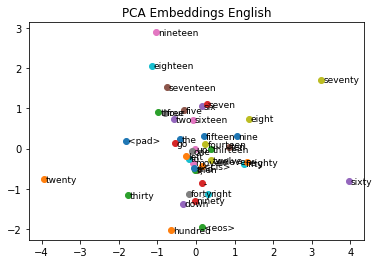

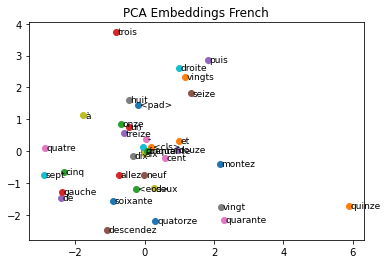

In [31]:
# PCA
pcaed_en = PCA_(2, to_pca_en)
pcaed_fr = PCA_(2, to_pca_fr)
plot_embeds(pcaed_en, list(words.iloc[en_idx,:]['label']), title="PCA Embeddings English")
plot_embeds(pcaed_fr, words.iloc[fr_idx,:]['label'], title="PCA Embeddings French")

t-SNEd into shape: (43, 2)
t-SNEd into shape: (37, 2)


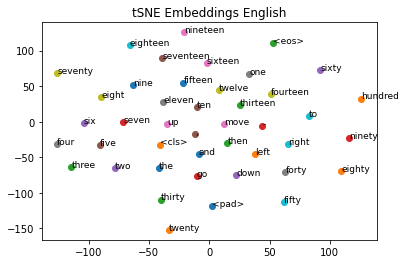

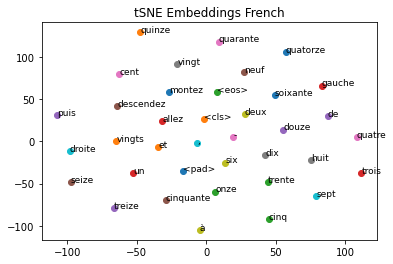

In [32]:
# TSNE
tsed_en = tSNE(to_pca_en)
tsned_fr = tSNE(to_pca_fr)
plot_embeds(tsed_en, list(words.iloc[en_idx,:]['label']), title="tSNE Embeddings English")
plot_embeds(tsned_fr, words.iloc[fr_idx,:]['label'], title="tSNE Embeddings French")

# Distance matrix

In [33]:
def plot_matrix(mat, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(mat)
    plt.title(title)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes, {'fontsize': 7})
    ax.set_yticklabels(classes, {'fontsize': 7})

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fig.colorbar(im)
    plt.show()

def vis_distance_matrix(df, classes, title, cos=True):
    """
    Visualize pairwise cosine distances between rows of the df.
    df should be a pandas dataframe of embedding vectors.
    """
    embeds = np.array(df)

    if cos:
        embeds = normalize(embeds, norm='l2', axis=1, copy=True, return_norm=False)
    dists = distance_matrix(embeds, embeds, p=2)
    
    plot_matrix(dists, classes, title)

    return dists


# Sentence Generation (run only if encoder)

In [34]:
def evaluate_encoder(model, data, criterion, device, type='Valid'):
    """
    Returns per-word cross entropy loss
    """
    model.eval()
    t = time.time()
    total_loss = 0
    total_words = 0
    with torch.no_grad():
        for batch_num, batch in enumerate(data[0]):
            x = data[2][batch_num].float() 
            total_words += int(torch.sum(data[1][batch_num]))
            y = batch

            pred = model(x.to(device))
            total_loss += float(criterion(pred, y))
            print("[Batch]: {}/{} in {:.5f} seconds".format(
                batch_num, len(data[0]), time.time() - t), end='\r', flush=True)
            t = time.time()

    print()
    print("[Total {} loss]: {:.5f}".format(type, total_loss))
    return total_loss / total_words

In [35]:
def get_perplexity(loss):
    """
    loss: per-word loss from evaluation
    A perplexity of random guessing is vocab size = 74. Anything lower is extremely good.
    """
    return 2 ** loss

In [36]:
# Load dataset iterators
iters = load_data(DATASET_PATH, INDEXED_DATA_PATH, LANG, BATCH_SIZE, device)
print('Finished loading data')

# Some datasets just have the train & test sets, so we just pretend test is valid
if len(iters) == 4:
    X_str, train_iter, val_iter, test_iter = iters
else:
    X_str, train_iter, test_iter = iters

Loading data...
Finished loading data


### Questions: 
- where are the FCL parameters?
    - Were the FCLs trained?

/Users/tjamesso/miniconda3/envs/nlp/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/tjamesso/miniconda3/envs/nlp/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/tjamesso/miniconda3/envs/nlp/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the origi

In [81]:
model = encoder
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
loss = evaluate_encoder(model, test_iter, criterion, device, type='Test')
print("Per word test loss: ", loss)

TypeError: forward() missing 1 required positional argument: 'h0'

In [40]:
print(get_perplexity(loss))

NameError: name 'loss' is not defined